## Lesson 07a: Unsupervised Learning - Comparing Different Clustering Algorithms


Last week, we used k-means clustering to the Enron financial dataset available in the [ud120-projects repo](https://www.github.com/udacity/ud120-projects). In today's lesson, we will work through a few other clustering algorithms and consider scenarios where one method is preferred over the others. The examples and code are drawn from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

We will look at the results of a few different clustering algorithms on "interesting" (or pathological) datasets with two independent variables. These examples will give us some intuition about which clustering algorithm might perform better in a given scenario. 


#### Preliminaries 
As usual, we start by loading the packages we are going to use. 

**Note:** We will use a function to plot the results of hierarchical clustering (called dendrograms) which is not available in `sklearn`. For tht reason, we will need to also load scipy, and the scipy package will need to be loaded in the environment you are using for this class. 
 - numpy
 - sklearn (this version of the notebook uses v0.18). 
 - matplotlib
 - seaborn
 - scipy

Run the cell below to load them
 
If you get an error loading scipy, please make sure it is loaded into your conda environment _before_ you start the Jupyter  notebook server

conda install -n mlnd scipy


In [1]:
#!/usr/bin/python 

try:
    import scipy
    print("Successfully imported scipy! (Version {})".format(scipy.__version__))
except ImportError:
    print("Could not import scipy!")

try:
    import numpy as np
    print("Successfully imported numpy! (Version {})".format(np.version.version))
except ImportError:
    pass
    
try:
    import matplotlib
    import matplotlib.pyplot as plt
    print("Successfully imported matplotlib! (Version {})".format(matplotlib.__version__))
except ImportError:
    pass

try:
    import sklearn
    print("Successfully imported sklearn! (Version {})".format(sklearn.__version__))
except ImportError:
    print("Could not import sklearn!")

try:
    from IPython.display import display
    from IPython.display import Image
    print("Successfully imported display from IPython.display and Image!")
except ImportError:
    print("Could not import display from IPython.display")

%matplotlib inline

Successfully imported scipy! (Version 1.0.0)
Successfully imported numpy! (Version 1.14.0)
Successfully imported matplotlib! (Version 2.1.2)
Successfully imported sklearn! (Version 0.19.1)
Successfully imported display from IPython.display and Image!


###  1 | Load Datasets

The idea of clustering is to find entities (records, rows) that are most similar to each other and group them together. All clustering algorithms rely on some measure of "distance" to determine similarity (sometimes called a dissimilarity measure). Many algorithms, e.g., the k-Means algorthm we used last time, uses Euclidean distance. Most clusterers in `sklearn` have a parameter for defining this distance. 

We will start by creating three toy datasets. Since these are datasets we are creating, we know the actual cluster assignments. This will be useful in "scoring" our algorithms later. In practice, though, we will not have labels for unsupervised learning and we will only be able to use some measure of cluster quality (such as silhouette score) to compare the results of different algorithms.

In [2]:
# Adapted from ipython notebook from http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html
import time

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

datasets = [noisy_circles, noisy_moons, blobs];

Since the algorithms are sensitive to distance by design, it is very important that all features (variables) are scaled evenly. In this section, we are using `StandardScaler` from `sklearn.preprocessing`.

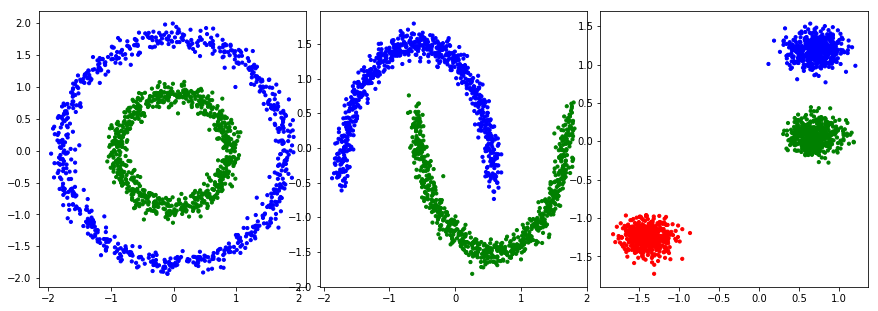

In [3]:
# We'll just take one dataset and look at its statistics before and after scaling
plt.figure(figsize=(4*len(datasets), 4));
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01);

for num, data in enumerate(datasets):
    X, y = data
    XS = StandardScaler().fit_transform(X)

    plt.subplot(1, 3, num+1)

    plt.scatter(XS[:, 0], XS[:, 1], color=colors[y].tolist(), s=10)
    

### 2 | Hierarchical Clustering

In the video lectures on Single Link Clustering, Charles and Michael described how HACs are constructed. You also need to choose how to measure the distance between two points (or elements), a point and a cluster, as well as two clusters. `sklearn` provides a single class [_AgglomerativeClustering_](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)  which has both the point-wise distance metric (_affinity_) and the method for calculating cluster distance (_linkage_) as parameters, along with the number of clusters (`n_clusters`)

_affinity_ takes on the default keyword `euclidean`. Other recognized values are `euclidean`, `l1`, `l2`, `manhattan`, `cosine`, or `precomputed`. If linkage is `ward`, only `euclidean` is accepted.

_linkage_ takes on the default keyword `ward`. Pther recognized values are `complete`, and `average`. There is no option to use the single-link method in `sklearn`. The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion.

`ward` minimizes the variance of the clusters being merged.
`average` uses the average of the distances of each observation of the two sets.
`complete` or maximum linkage uses the maximum distances between all observations of the two sets.


To determine which clustering result better matches the original labels of the samples, we can use ```adjusted_rand_score``` which is an *external cluster validation index* yielding a score between -1 and 1, where 1 means two clusterings are identical to their **true** grouping in a dataset (regardless of what label is assigned to each cluster).

Let's import the clustering class and this metric [`adjusted_rand_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) for an indication of how well our clustering algorithm does with these generated datasets

In [4]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

The next cell defines a helper function that performs HA clustering using three linkage criteria for the dataset passed. Try it with each of the toy datasets we created to 

In [5]:
def plot_clusters(dataset, n_clusters):
    X, y = dataset
    normalized_X = StandardScaler().fit_transform(X)
    ward = AgglomerativeClustering(n_clusters=n_clusters)
    ward_pred = ward.fit_predict(normalized_X)

    complete = AgglomerativeClustering(n_clusters=n_clusters, linkage="complete")
    complete_pred = complete.fit_predict(normalized_X)

    avg = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    avg_pred = avg.fit_predict(normalized_X)


    ward_ar_score = adjusted_rand_score(y, ward_pred)
    complete_ar_score = adjusted_rand_score(y, complete_pred)
    avg_ar_score = adjusted_rand_score(y, avg_pred)

    print( "Scores: \nWard: {:5.4f}\nComplete: {:5.4f}\nAverage: {}".format(ward_ar_score, complete_ar_score, avg_ar_score))

    plt.figure(figsize=(3*len(datasets) +4, 4));
    plt.subplots_adjust(left=.05, right=.95, bottom=.001, top=.96, wspace=0.15, hspace=.01);
    plot_labels = ("Ward", "Complete", "Average")
    for num, pred in enumerate((ward_pred, complete_pred, avg_pred)):
        plt.subplot(1, 3, num+1)

        plt.scatter(normalized_X[:,0], normalized_X[:,1], color=colors[pred].tolist(), s=10)
        plt.text(.99, 0.05, plot_labels[num],
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')


**EXERCISE**

Perform clustering with the three toy data sets and three linkage criteria using clusters 2, 3, and 4. What was the best (highest ```adjusted_rand_score```) linkage type and number of clusters for the three datasets? 

**Answer:** The take-home lesson here is that the three HAC methods give similar results and recovert he original clusters perfectly for only the _blobs_ dataset since it is the one where the clusters are convex most cleanly separated in space.

Dataset | _N_ | Ward | Complete | Average 
 ------- | -------- | ------- | --------- | ------
 `noisy_circles` | 2 | 0.0002 | 0.0038 |-0.0006
     | 3 | 0.003 | 0.004  | 0.005 
     | 4 | 0.003 | 0.004  | 0.014 
 `noisy_moons` | 2  | 0.56 | 0.60 | 0.73
     | 3 | 0.47 | 0.50  | 0.62 
     | 4 | 0.50 | 0.36  | 0.46      
 `blobs` | 2 | 0.57 | 0.57 | 0.57
     | 3 | 1.0 | 1.0  | 1.0 
     | 4 | 0.92 | 0.89  | 1.0 

Scores: 
Ward: 0.9177
Complete: 0.8928
Average: 0.9990003327778144


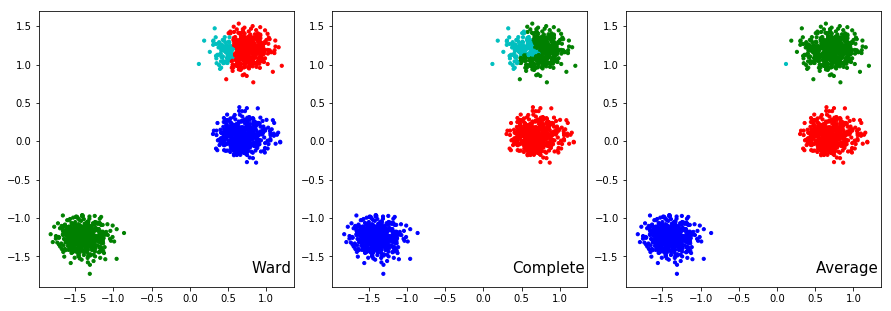

In [6]:
plot_clusters(blobs, 4)

### 3 | Dendrogram visualization with scipy

It is also interesting to visualize how these clusters are built up. The cells below calculate and plot a "dendrogram" (an entity with many levels of branching). A key point to remember is that every horizontal line identifying two clusters that get merged has its own height (difficult to see because of the scaling). Once the complete tree structure as been created, you can draw a horizontal line at an appropriate height to get an arbitrary number of clusters (of course can't have more than the number of leaves you started with!)

Let's visualize the clustering result for `blobs` using 3 clusters and the ward linkage method. 

To do that, we'll need to use Scipy's [```linkage```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) function to perform the clusterirng again so we can obtain the linkage matrix it will later use to visualize the hierarchy using [```dendrogram```](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.cluster.hierarchy.dendrogram.html)

The `height` (y-axis) at which the clusters are merged are scaled to the "distance" between the clusters. For the cleanly separated clusters in `blobs`, the dendrogram also shows a leanly delineated "tree" up to three clusters, then they begin to run together. 

In [7]:
# Import scipy's linkage and dendrogram functions to conduct the clustering
from scipy.cluster.hierarchy import dendrogram, linkage

X, y = blobs
normalized_X = StandardScaler().fit_transform(X)

# Specify the linkage type. Scipy accepts 'ward', 'complete', 'average', as well as other values
# Pick the one that resulted in the highest Adjusted Rand Score
linkage_type = 'ward'

linkage_matrix = linkage(normalized_X, linkage_type)

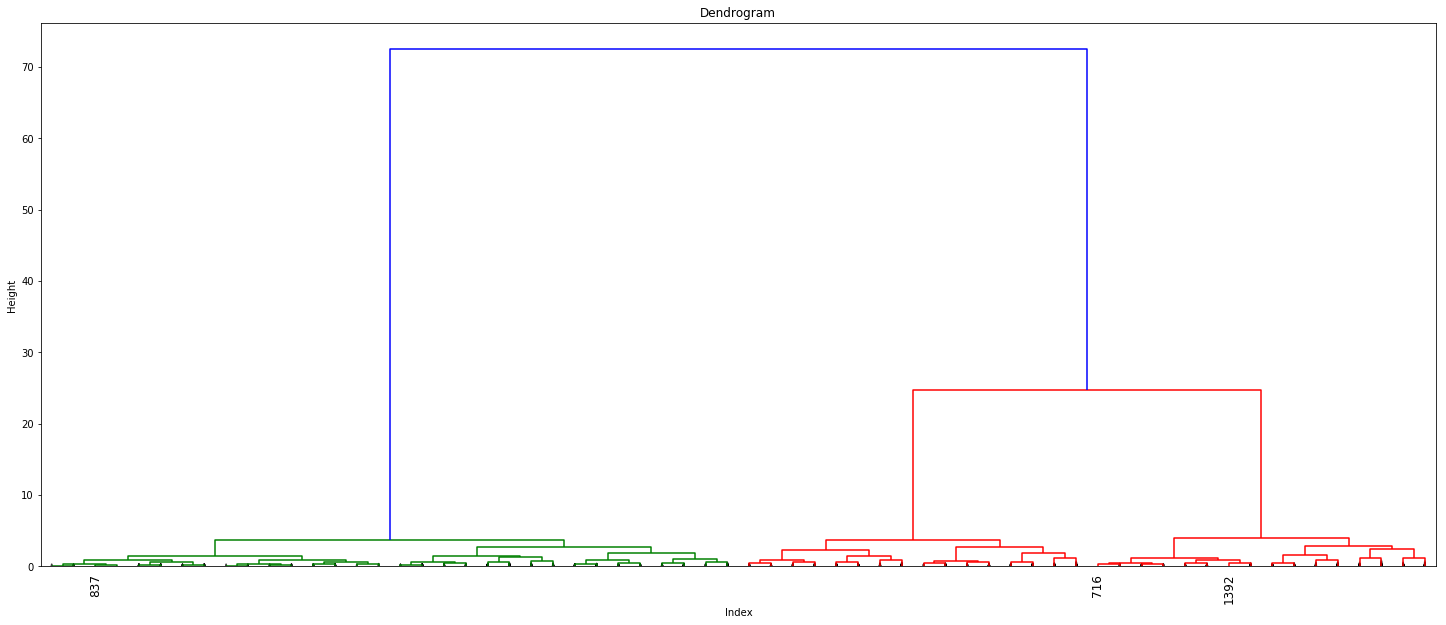

In [8]:
## https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Plotting-a-Dendrogram
#
# calculate and plot the dendrogram
plt.figure(figsize=(25, 10))
plt.title('Dendrogram')
plt.xlabel('Index')
plt.ylabel('Height')

dendrogram(
    linkage_matrix,
    truncate_mode='level',  # show only the highest p levels of merged clusters
    p=5,  # show only the last p levels of merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)

plt.show()

### 4 | DBSCAN

As you likely saw earlier, AgglomerativeClustering doesn't work too well for the ```noisy_moons``` or ```noisy_circles``` datasets. Let's try DBSCAN on the three now.

[DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) (Density-Based Spatial Clustering of Applications with Noise -- an algorithm not discussed in the lectures, but is well-researched and known to be fairly robust). Run he cell below to see the results of clustering with the default parameters using DBSCAN.


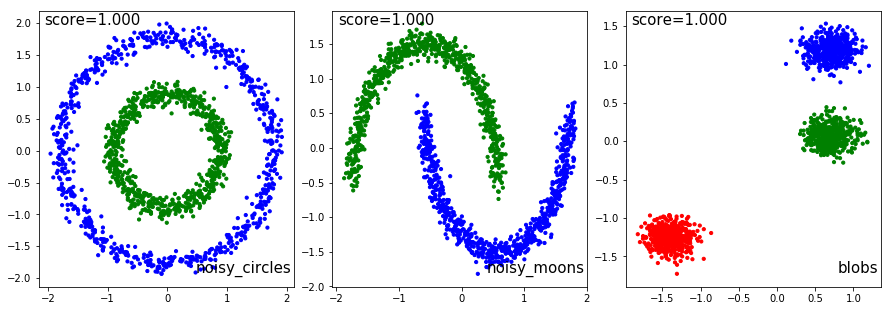

In [32]:
from sklearn.cluster import DBSCAN

plt.figure(figsize=(3*len(datasets) +4, 4));
plt.subplots_adjust(left=.05, right=.95, bottom=.001, top=.96, wspace=0.15, hspace=.01);
plot_labels = ("noisy_circles", "noisy_moons", "blobs")

for num, dataset in enumerate(datasets):
    X, y = dataset
    normalized_X = StandardScaler().fit_transform(X)
    dbscan = DBSCAN(eps=0.3, min_samples=5)
    pred = dbscan.fit_predict(normalized_X)
    plt.subplot(1, 3, num+1)
    ascore = adjusted_rand_score(y, pred)

    plt.scatter(normalized_X[:,0], normalized_X[:,1], color=colors[pred].tolist(), s=10)
    plt.text(.99, 0.05, plot_labels[num],
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plt.text(.4, 0.95, "score={:5.3f}".format(ascore),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')


**EXERCISE**

The default values of the two important parameters ```eps``` and ```min_samples``` doesn't work well for our chosen datasets. Try changing ```eps``` to see if you can get higher ```adjusted_rand_score``` for these datasets.

**Answer:   **  
The clusters are perfectly recovered for value of `eps` between 0.1 and 0.3. 


### 5 | Gaussian Mixture Models and Expectation Maximization (EM)

The mixture model is inherently different from the other clustering algorithms we used in that  it determines a probability that any given case belongs to one of the _n_ clusters that it was supposed to find rather than a hard (0 or 1) assignment to a cluster. This can be very helpful when the clusters are overlapping.

Consider this simplified description of the mathematics behind _K_-means. We have a set of _N_ observations ($ x \epsilon \{1, ... , N\} $), and the algorithm is tasked with finding the best assignment of these points to the _K_ clusters (as well as finding the cluster centers). Let's introduce an indicator variable $ z_{i,j} $ that associates a point $ x_i $ with center $ k \varepsilon \{1,..,K\} $. $ z_{i,j} $ is zero for all combinations of $ i $ and $ j $ except when $ j = k $, where $k $ is the cluster to which $ x_i $ is assigned. The objective or cost function, $ J $ is the sum of squared distances (or mean squared distance if you want to scale it by the number of points) for this cluster assignment:

$$\large J = \Sigma_{i=1}^{N} \cdot \Sigma_{j=1}^K z_{i,j} \| x_i - \mu_k \|^2 $$

The _K_-means algorithm therefore needs to find values of  $ z_{i,j} $ and $ \mu_k $ that minimizes $ J $. There is closed form solution for this as the cost function is easily differentiable.

In a gaussian mixture model, the "points" in our dataset are assumed to be drawn from one or more i.i.d. (independent and identically distributed) random variables. The algorithm needs to be supplied the number of these i.i.d.s (i.e., the number of clusters); it then determines the probability that a given point belongs to each of the clusters it identifies. In words (the words of Charles and Michael), we assume:
- the data was generated by a underlying set of $ K $ i.i.d.s
- each i.i.d. is characterized by the Normal distribution, i.e., $\large \mathcal{N}( x | \mu_k, \sigma_k) $
- we don't know what the $ \mu_k $ and $ \sigma_k $ are (for simplicity we consider the $ \sigma $ the same for all i.i.d.s
- but we want to use our observations of each point $ x_n $ to deduce the the set $ \{ \mu_1, \mu_2, ... , \mu_K, \sigma \} $

We want to determine a set of $ \mu_k $ that maximizes the probability of observing the set of $ x_n $. However, unlike the _K_-means case, there isn't a closed form solution for solving this problem when there are more than one i.i.d involved. The Expectation Maximization algorithm achieves this goal by choosing some centers (randomly), calculating the resulting set of $ z_{i,j} $, i.e., cluster assignments, that maximizes the probabiity that the dataset was derived from this set of i.i.d.s. It then calculates the centers from these $ z_{i,j} $, iterating until the centers stop changing. 

_Implementation_
There are two things to note:
 - GaussianMixture is in the ```sklearn.mixture``` (not ```sklearn.cluster```) package
 - it does not have a fit_predict function, so we have to fit first, then use the predict function

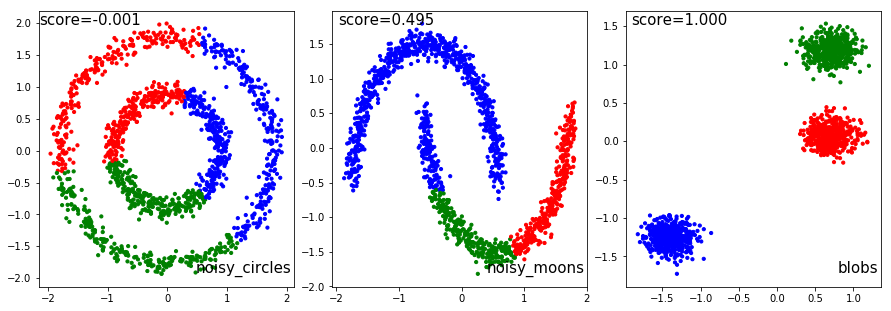

In [15]:
from sklearn.mixture import GaussianMixture

plt.figure(figsize=(3*len(datasets) +4, 4));
plt.subplots_adjust(left=.05, right=.95, bottom=.001, top=.96, wspace=0.15, hspace=.01);
plot_labels = ("noisy_circles", "noisy_moons", "blobs")

for num, dataset in enumerate(datasets):
    X, y = dataset
    normalized_X = StandardScaler().fit_transform(X)
    G = GaussianMixture(n_components=3).fit(normalized_X)
    pred = G.predict(normalized_X)
    plt.subplot(1, 3, num+1)
    ascore = adjusted_rand_score(y, pred)

    plt.scatter(normalized_X[:,0], normalized_X[:,1], color=colors[pred].tolist(), s=10)
    plt.text(.99, 0.05, plot_labels[num],
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')
    plt.text(.4, 0.95, "score={:5.3f}".format(ascore),
             transform=plt.gca().transAxes, size=15,
             horizontalalignment='right')


**EXERCISE: ** Try different values of ```n_components``` to find values that maximize the ```adjusted_rand_score```. Why does GMM not work well for the ```noisy_moons``` and ```noisy_circles``` datasets?

** Answer **:
    We are able to recover only the `blobs` dataset using GMM. This makes sense as the other two datasets exhibit a geometry that doesn't match gaussians in general which have their peak density closest to the center.